In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, Normalizer

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from pmdarima import auto_arima
import random
import itertools
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
import lightgbm as LGBMRegressor
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.decomposition import PCA, KernelPCA
from tqdm import tqdm
import itertools

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
building = pd.read_csv('./building_info.csv')

In [3]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis = 1, inplace=True)

test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

building = building.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})


In [4]:
train = pd.merge(train, building, on='building_number', how='left')
test = pd.merge(test, building, on='building_number', how='left')

In [5]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [6]:
train['date'].unique()

array(['2022-06-01T00:00:00.000000000', '2022-06-01T01:00:00.000000000',
       '2022-06-01T02:00:00.000000000', ...,
       '2022-08-24T21:00:00.000000000', '2022-08-24T22:00:00.000000000',
       '2022-08-24T23:00:00.000000000'], dtype='datetime64[ns]')

In [7]:
train['rainfall'] = train['rainfall'].fillna(0)
train['sunshine'] = train['sunshine'].fillna(0)
train['solar_radiation'] = train['solar_radiation'].fillna(0)

In [8]:
weekend = [0 for _ in range(len(train))]

for i in train.query('date.dt.dayofweek == 6').index:
    weekend[i] = 1
    
for i in train.query('date.dt.dayofweek == 5').index:
    weekend[i] = 1
    
train['sudo_weekend'] = weekend
train

,building_number,date,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,sudo_weekend
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,건물기타,110634.00,39570.00,-,-,-,0
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,건물기타,110634.00,39570.00,-,-,-,0
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,0.0,0.0,974.88,건물기타,110634.00,39570.00,-,-,-,0
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,0.0,0.0,953.76,건물기타,110634.00,39570.00,-,-,-,0
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,0.0,0.0,986.40,건물기타,110634.00,39570.00,-,-,-,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,0.5,0.0,881.04,호텔및리조트,57497.84,40035.23,-,-,-,0
203996,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,0.0,0.0,798.96,호텔및리조트,57497.84,40035.23,-,-,-,0
203997,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,0.0,0.0,825.12,호텔및리조트,57497.84,40035.23,-,-,-,0
203998,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,0.0,0.0,640.08,호텔및리조트,57497.84,40035.23,-,-,-,0


In [9]:
# 6월6일 8월15일 공휴일

holiday = [f'2022-06-06 0{i}:00:00' for i in range(10)]
holiday.extend([f'2022-06-06 {i}:00:00' for i in range(10,24)])
holiday.extend([f'2022-08-15 0{i}:00:00' for i in range(10)])
holiday.extend([f'2022-08-15 {i}:00:00' for i in range(10,24)])
holiday

['2022-06-06 00:00:00',
 '2022-06-06 01:00:00',
 '2022-06-06 02:00:00',
 '2022-06-06 03:00:00',
 '2022-06-06 04:00:00',
 '2022-06-06 05:00:00',
 '2022-06-06 06:00:00',
 '2022-06-06 07:00:00',
 '2022-06-06 08:00:00',
 '2022-06-06 09:00:00',
 '2022-06-06 10:00:00',
 '2022-06-06 11:00:00',
 '2022-06-06 12:00:00',
 '2022-06-06 13:00:00',
 '2022-06-06 14:00:00',
 '2022-06-06 15:00:00',
 '2022-06-06 16:00:00',
 '2022-06-06 17:00:00',
 '2022-06-06 18:00:00',
 '2022-06-06 19:00:00',
 '2022-06-06 20:00:00',
 '2022-06-06 21:00:00',
 '2022-06-06 22:00:00',
 '2022-06-06 23:00:00',
 '2022-08-15 00:00:00',
 '2022-08-15 01:00:00',
 '2022-08-15 02:00:00',
 '2022-08-15 03:00:00',
 '2022-08-15 04:00:00',
 '2022-08-15 05:00:00',
 '2022-08-15 06:00:00',
 '2022-08-15 07:00:00',
 '2022-08-15 08:00:00',
 '2022-08-15 09:00:00',
 '2022-08-15 10:00:00',
 '2022-08-15 11:00:00',
 '2022-08-15 12:00:00',
 '2022-08-15 13:00:00',
 '2022-08-15 14:00:00',
 '2022-08-15 15:00:00',
 '2022-08-15 16:00:00',
 '2022-08-15 17:

In [10]:
holy_idx = [train[train['date']==i].index for i in holiday]

ans = [0 for _ in range(204000)]
for t in holy_idx:
    for idx in t:
        ans[idx] = 1

train['sudo_holiday'] = ans
train

,building_number,date,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,sudo_weekend,sudo_holiday
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,건물기타,110634.00,39570.00,-,-,-,0,0
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,건물기타,110634.00,39570.00,-,-,-,0,0
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,0.0,0.0,974.88,건물기타,110634.00,39570.00,-,-,-,0,0
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,0.0,0.0,953.76,건물기타,110634.00,39570.00,-,-,-,0,0
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,0.0,0.0,986.40,건물기타,110634.00,39570.00,-,-,-,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,0.5,0.0,881.04,호텔및리조트,57497.84,40035.23,-,-,-,0,0
203996,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,0.0,0.0,798.96,호텔및리조트,57497.84,40035.23,-,-,-,0,0
203997,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,0.0,0.0,825.12,호텔및리조트,57497.84,40035.23,-,-,-,0,0
203998,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,0.0,0.0,640.08,호텔및리조트,57497.84,40035.23,-,-,-,0,0


In [11]:
# pd.date_range('2022-06-01 00:00:00','2022-08-24 23:00:00',freq='h')

In [12]:
# data = [train[train['building_type'] == i].reset_index(drop=True) for i in train.building_type.unique()]


<AxesSubplot: >

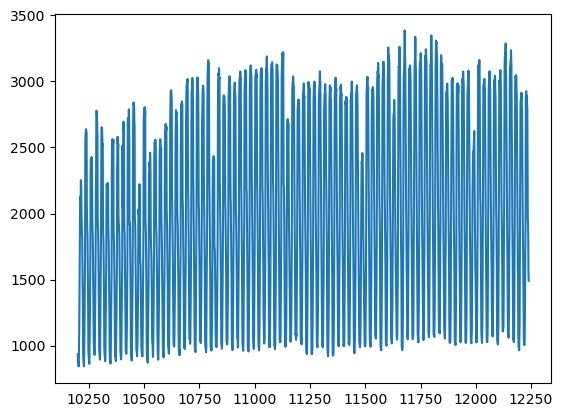

In [13]:
train[train['building_number']==6]['power_consumption'].plot()

In [14]:
building['building_type'].unique()

array(['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소',
       '지식산업센터', '할인마트', '호텔및리조트'], dtype=object)

<AxesSubplot: >

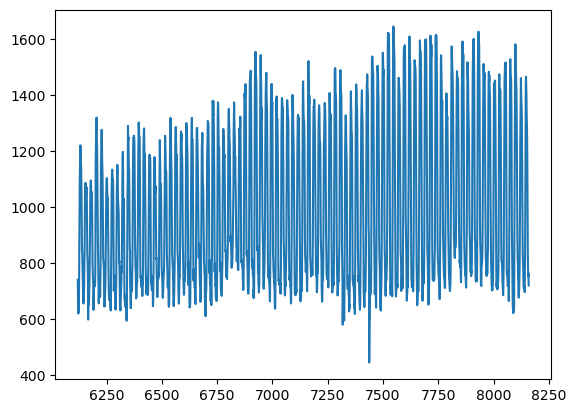

In [15]:
train[train['building_number']==4]['power_consumption'].plot()

In [16]:
train[(train['building_number']==4)&(train['power_consumption']<600)]

,building_number,date,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,sudo_weekend,sudo_holiday
6167,4,2022-06-02 23:00:00,19.2,0.0,2.7,83.0,0.0,0.0,598.14,건물기타,74312.98,34419.62,60,-,-,0,0
6341,4,2022-06-10 05:00:00,17.4,0.0,1.8,89.0,0.0,0.0,594.00,건물기타,74312.98,34419.62,60,-,-,0,0
7318,4,2022-07-20 22:00:00,26.2,0.3,1.4,81.0,0.0,0.0,580.14,건물기타,74312.98,34419.62,60,-,-,0,0
7325,4,2022-07-21 05:00:00,21.2,0.7,3.2,94.0,0.0,0.0,595.26,건물기타,74312.98,34419.62,60,-,-,0,0
7438,4,2022-07-25 22:00:00,27.3,0.0,1.4,75.0,0.0,0.0,444.96,건물기타,74312.98,34419.62,60,-,-,0,0
7439,4,2022-07-25 23:00:00,26.8,0.0,1.9,79.0,0.0,0.0,584.46,건물기타,74312.98,34419.62,60,-,-,0,0


<AxesSubplot: >

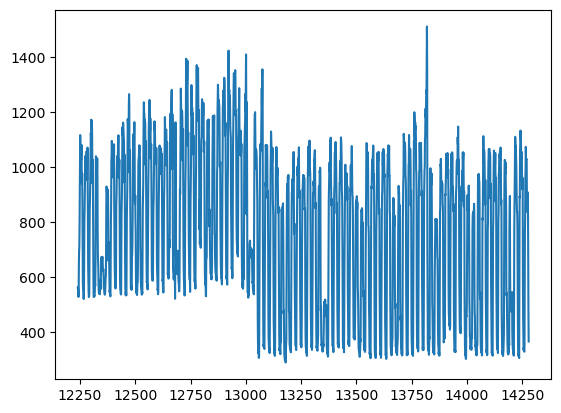

In [17]:
train[train['building_number']==7]['power_consumption'].plot()

<AxesSubplot: >

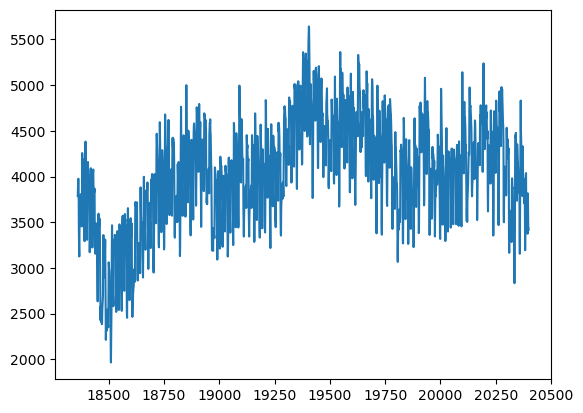

In [18]:
train[train['building_number']==10]['power_consumption'].plot()

<AxesSubplot: >

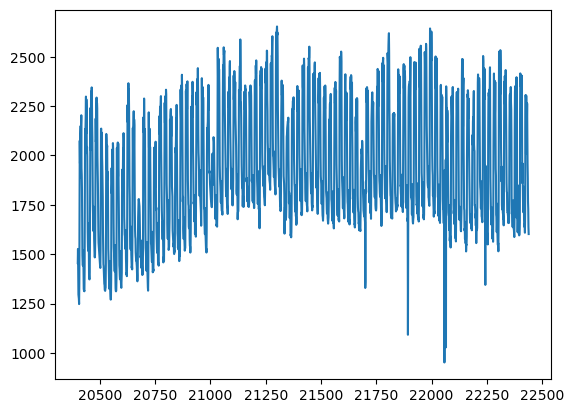

In [19]:
train[train['building_number']==11]['power_consumption'].plot()

<AxesSubplot: >

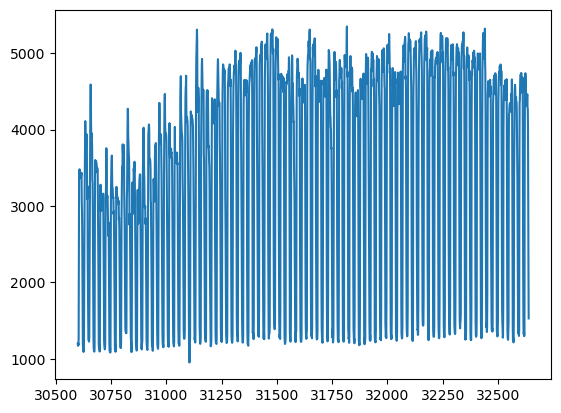

In [20]:
train[train['building_number']==16]['power_consumption'].plot()

In [21]:
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters=12, random_state=0, n_init="auto")
train = train.drop(['power_consumption','date','building_type','solar_power_capacity','ess_capacity','pcs_capacity','sudo_weekend','sudo_holiday','solar_radiation','sunshine'],axis=1)
train = train.dropna()
cluster.fit(train)

KMeans(n_clusters=12, n_init='auto', random_state=0)

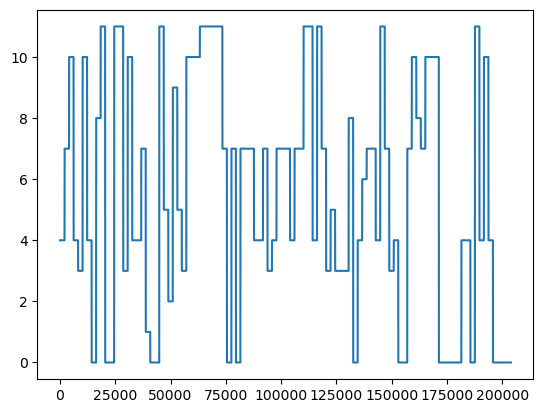

In [22]:
plt.plot(cluster.labels_)

In [23]:
test = test.drop(['date','building_type','solar_power_capacity','ess_capacity','pcs_capacity'],axis=1)
test = test.dropna()

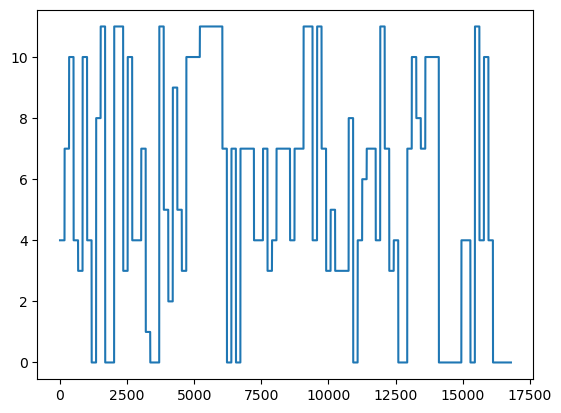

In [24]:
plt.plot(cluster.predict(test))